<a href="https://www.kaggle.com/ryanglasnapp/sakura-predictions?scriptVersionId=87843987" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Introduction
The model in this notebook is based on *Deep learning for time series classification: a review* by Ismail Fawaz, Hassan and Forestier, Germain and Weber, Jonathan and Idoumghar, Lhassane and Muller, and Pierre-Alain.

See the References sections at the bottom for further detail. 

Work in Progress: Any comments or suggestions are appreciated.


## Data Loading and Cleaning

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
!pip install july

import july
from july.utils import date_range



### Data Testing
Doing some basic testing with a small subset of data.

In [3]:
city_subset_list = ['Kyoto', 'Osaka','Nara']
city_subset = {}

for city in city_subset_list:
    # Note: Individual is not spelled correctly in the dataset, whoops.
    city_subset[city] = pd.read_csv(f'../input/japanese-temperature-data/individal_cities/{city}.csv', parse_dates=[0])
    city_subset[city].set_index('Date',inplace=True)
    
first_bloom = pd.read_csv('../input/japanese-cherry-blossom-data/sakura_first_bloom_dates.csv')
full_bloom = pd.read_csv('../input/japanese-cherry-blossom-data/sakura_full_bloom_dates.csv')


first_bloom.set_index('Site Name', inplace=True)
full_bloom.set_index('Site Name', inplace=True)

In [4]:
city_subset['Kyoto'].columns = city_subset['Kyoto'].columns.str.replace('.* Avg Temp','Avg Temp')

city_subset['Kyoto'].loc[:,'7 day mean'] = city_subset['Kyoto'].loc[:,'Avg Temp'].rolling(7).mean()
city_subset['Kyoto'].loc[:,'14 day mean'] = city_subset['Kyoto'].loc[:,'Avg Temp'].rolling(14).mean()
city_subset['Kyoto'].loc[:,'28 day mean'] = city_subset['Kyoto'].loc[:,'Avg Temp'].rolling(28).mean()

city_subset['Kyoto'].loc[:,'Bloom Status'] = 0
for col in first_bloom:
    if str.isnumeric(col):
        if col >= '1955' and col <= '2018':
            city_subset['Kyoto'].loc[first_bloom.loc['Kyoto', col]:full_bloom.loc['Kyoto', col],'Bloom Status'] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


Math for posterity:

Original form for End of a batch:
batch_idx * batch_size * stride + (batch_size - 1)* stride + length

Simplified:
(batch_idx + 1)* batch_sz * stride - stride + length


Size of the data before batching should be such that for any integer n:

data_size = (n * batch_size-1)* stride + length 

So:

require: (data_size - length)/stride + 1 % batch_size == 0 

In [5]:
length = 28
stride = 14
batch_sz = 128
batch_len = length + (batch_sz - 1)*stride
train_pct = 0.70

train_max_points = int(city_subset['Kyoto'].loc[:,'Avg Temp'].shape[0] * train_pct)
train_num_batches = ((train_max_points - length)/stride + 1 ) // batch_sz
train_sz = int((train_num_batches * batch_sz - 1)*stride + length)
train_end_date = city_subset['Kyoto'].index[train_sz - 1]

test_max_points = city_subset['Kyoto'].loc[train_end_date:,'Avg Temp'].shape[0] 
test_num_batches = ((test_max_points - length)/stride + 1 ) // batch_sz
test_sz = int((test_num_batches * batch_sz - 1)*stride + length)
test_end_date = city_subset['Kyoto'].index[train_sz+test_sz - 2]

X_train = city_subset['Kyoto'].loc[:train_end_date,'Avg Temp']
y_train = city_subset['Kyoto'].loc[:train_end_date,'Bloom Status'].shift(-length+1, fill_value=0).rolling(length).max()

X_test = city_subset['Kyoto'].loc[train_end_date:test_end_date,'Avg Temp']
y_test = city_subset['Kyoto'].loc[train_end_date:test_end_date,'Bloom Status'].shift(-length+1, fill_value=0).rolling(length).max()

# Note for future self: Use end_index to split this into a training set and validation set, as well as contraining things to clean multiples of the batch size
dataset = tf.keras.utils.timeseries_dataset_from_array(X_train, y_train, sequence_length=length, sequence_stride=stride, batch_size=batch_sz)
dataset_test = tf.keras.utils.timeseries_dataset_from_array(X_test, y_test, sequence_length=length, sequence_stride=stride, batch_size=batch_sz)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

In [6]:
n=1
s=(n-1)*104-1
f=n*104-1
y_train[s*stride+28:f*stride+28].tail(28)

Date
1958-12-13    0.0
1958-12-14    0.0
1958-12-15    0.0
1958-12-16    0.0
1958-12-17    0.0
1958-12-18    0.0
1958-12-19    0.0
1958-12-20    0.0
1958-12-21    0.0
1958-12-22    0.0
1958-12-23    0.0
1958-12-24    0.0
1958-12-25    0.0
1958-12-26    0.0
1958-12-27    0.0
1958-12-28    0.0
1958-12-29    0.0
1958-12-30    0.0
1958-12-31    0.0
1959-01-01    0.0
1959-01-02    0.0
1959-01-03    0.0
1959-01-04    0.0
1959-01-05    0.0
1959-01-06    0.0
1959-01-07    0.0
1959-01-08    0.0
1959-01-09    0.0
Name: Bloom Status, dtype: float64

In [7]:
list(dataset.as_numpy_iterator())[0][1][6]
#city_subset['Kyoto'].index[batch_len*1 - 1]


2022-02-14 20:10:53.338103: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1.0

The following model is from *Deep learning for time series classification: a review* by Ismail Fawaz, Hassan and Forestier, Germain and Weber, Jonathan and Idoumghar, Lhassane and Muller, and Pierre-Alain.

In [8]:
def build_model(input_shape, batch_size, nb_classes):
    n_feature_maps = 64

    input_layer = keras.layers.Input(input_shape,batch_size=batch_size)

    # BLOCK 1

    conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)

    # BLOCK 2

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)

    # BLOCK 3

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)

    # FINAL

    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

    output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy'])

    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)

    return model

In [9]:
resnet = build_model((28,1), batch_sz, 1)

#resnet.summary()

In [10]:
data_iter = iter(dataset)
#input, output = data_iter.get_next()
#input_shape = input.shape

for input, output in data_iter:
    resnet.fit(input, output, batch_size=batch_sz, epochs=4, validation_data=dataset_test, validation_steps=4)
    
#resnet.fit(dataset, batch_size=batch_sz, epochs=4, validation_data=dataset_test)

Epoch 1/4
1/1 [==============================] - 4s 4s/step - loss: nan - accuracy: 0.0938 - val_loss: nan - val_accuracy: 0.9004
Epoch 2/4
1/1 [==============================] - 0s 473ms/step - loss: nan - accuracy: 0.8906 - val_loss: nan - val_accuracy: 0.9004
Epoch 3/4
1/1 [==============================] - 0s 457ms/step - loss: nan - accuracy: 0.8906 - val_loss: nan - val_accuracy: 0.9004
Epoch 4/4
1/1 [==============================] - 0s 462ms/step - loss: nan - accuracy: 0.8906 - val_loss: nan - val_accuracy: 0.9004
Epoch 1/4
1/1 [==============================] - 0s 465ms/step - loss: nan - accuracy: 0.9062 - val_loss: nan - val_accuracy: 0.9004
Epoch 2/4
1/1 [==============================] - 0s 469ms/step - loss: nan - accuracy: 0.9062 - val_loss: nan - val_accuracy: 0.9004
Epoch 3/4
1/1 [==============================] - 0s 475ms/step - loss: nan - accuracy: 0.9062 - val_loss: nan - val_accuracy: 0.9004
Epoch 4/4
1/1 [==============================] - 0s 457ms/step - loss: n

# Visualizations

In [11]:
resnet.predict(city_subset['Kyoto'].loc['2010-01-01':'2015-12-31','Avg Temp'])

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

In [12]:
dates = date_range("2015-01-01", "2015-12-31")


<AxesSubplot:>

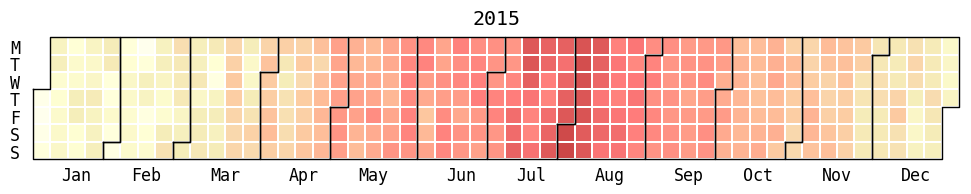

In [13]:
july.heatmap(dates, city_subset['Kyoto'].loc['2015-01-01':'2015-12-31','Avg Temp'], month_grid=True)

## Testing
This is a collection of some old cells that I'm keeping out of the way in case I need them again for testing.

In [14]:
y_train.head(32)

#city_subset['Kyoto'].loc[:'1955-02-01','Bloom Status'].shift(-length).rolling(length).max()
city_subset['Kyoto'].loc[:'1955-05-01','Bloom Test'] = city_subset['Kyoto'].loc[:'1955-05-01','Bloom Status'].shift(-length+1, fill_value=0).rolling(length).max()

city_subset['Kyoto'].loc['1955-03-01':'1955-04-28',['Bloom Test', 'Bloom Status']].head(28)

,Bloom Test,Bloom Status
Date,,
1955-03-01,1.0,0
1955-03-02,1.0,0
1955-03-03,1.0,0
1955-03-04,1.0,0
1955-03-05,1.0,0
1955-03-06,1.0,0
1955-03-07,1.0,0
1955-03-08,1.0,0
1955-03-09,1.0,0


In [15]:
dataset_test = tf.keras.utils.timeseries_dataset_from_array(np.linspace(0,199,200), targets=None, sequence_length=10, sampling_rate=1, sequence_stride=5, batch_size=4)
for testset in iter(dataset_test):
 
   print(testset)
    


tf.Tensor(
[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
 [10. 11. 12. 13. 14. 15. 16. 17. 18. 19.]
 [15. 16. 17. 18. 19. 20. 21. 22. 23. 24.]], shape=(4, 10), dtype=float64)
tf.Tensor(
[[20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
 [25. 26. 27. 28. 29. 30. 31. 32. 33. 34.]
 [30. 31. 32. 33. 34. 35. 36. 37. 38. 39.]
 [35. 36. 37. 38. 39. 40. 41. 42. 43. 44.]], shape=(4, 10), dtype=float64)
tf.Tensor(
[[40. 41. 42. 43. 44. 45. 46. 47. 48. 49.]
 [45. 46. 47. 48. 49. 50. 51. 52. 53. 54.]
 [50. 51. 52. 53. 54. 55. 56. 57. 58. 59.]
 [55. 56. 57. 58. 59. 60. 61. 62. 63. 64.]], shape=(4, 10), dtype=float64)
tf.Tensor(
[[60. 61. 62. 63. 64. 65. 66. 67. 68. 69.]
 [65. 66. 67. 68. 69. 70. 71. 72. 73. 74.]
 [70. 71. 72. 73. 74. 75. 76. 77. 78. 79.]
 [75. 76. 77. 78. 79. 80. 81. 82. 83. 84.]], shape=(4, 10), dtype=float64)
tf.Tensor(
[[ 80.  81.  82.  83.  84.  85.  86.  87.  88.  89.]
 [ 85.  86.  87.  88.  89.  90.  91.  92.  93.  94.]
 [ 90.  91.  92.  93.  

In [16]:
dataset.__dir__()

['_input_dataset',
 '_batch_size',
 '_drop_remainder',
 '_structure',
 '_variant_tensor_attr',
 '_self_setattr_tracking',
 '_self_unconditional_checkpoint_dependencies',
 '_self_unconditional_dependency_names',
 '_self_unconditional_deferred_dependencies',
 '_self_update_uid',
 '_self_name_based_restores',
 '_self_saveable_object_factories',
 '_variant_tracker',
 '_graph_attr',
 '_options_attr',
 '__module__',
 '__doc__',
 '__init__',
 'element_spec',
 '__abstractmethods__',
 '_abc_impl',
 '_inputs',
 '_variant_tensor',
 '_as_serialized_graph',
 '_trace_variant_creation',
 '_graph',
 '_functions',
 '_options',
 '_options_tensor_to_options',
 'options',
 '_apply_debug_options',
 '__iter__',
 '__bool__',
 '__nonzero__',
 '__len__',
 '__repr__',
 'as_numpy_iterator',
 '_flat_shapes',
 '_flat_types',
 '_flat_structure',
 '_type_spec',
 'from_tensors',
 'from_tensor_slices',
 '_GeneratorState',
 'from_generator',
 'range',
 'zip',
 'concatenate',
 'prefetch',
 'list_files',
 'repeat',
 'enu

In [17]:
idx = 7
#X.iloc[14*idx:14*idx+28]
city_subset['Kyoto'].loc[:,['Avg Temp','Bloom Status']].iloc[14*idx:14*idx+28]

,Avg Temp,Bloom Status
Date,,
1955-04-09,16.8,0
1955-04-10,16.9,0
1955-04-11,17.0,0
1955-04-12,17.8,0
1955-04-13,18.6,0
1955-04-14,19.5,0
1955-04-15,17.3,0
1955-04-16,18.1,0
1955-04-17,17.0,0


In [18]:
list(dataset_test.as_numpy_iterator())[-1][0].shape

(10,)

## References

@article{IsmailFawaz2018deep,
  Title                    = {Deep learning for time series classification: a review},
  Author                   = {Ismail Fawaz, Hassan and Forestier, Germain and Weber, Jonathan and Idoumghar, Lhassane and Muller, Pierre-Alain},
  journal                  = {Data Mining and Knowledge Discovery},
  Year                     = {2019},
  volume                   = {33},
  number                   = {4},
  pages                    = {917--963},
}


### 